In [2]:
# 爬虫前务必设置好自动测试浏览器路径 ******第27，30行
# 更改搜索标题	*************************第124行
# 更改爬去文章数目 **********************第43行，对应更改第41行翻页数目
# 程序会自动创建excel，路径更改 **********第123，129，153行

# 100条话题或回答运行时间约10分钟，具体取决于电脑性能和网速
from bs4 import BeautifulSoup 
import pandas as pd
import time
from tqdm import tqdm
import requests
from pprint import pprint
import xlwt,xlrd
from xlutils.copy import copy
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.common.exceptions import NoSuchElementException 

####################### 自动测试浏览器变量设置 #######################
# Cookie 和 User-agent 没用，懒得改了
Cookie = {'domain': '.weibo.com', 'expiry': 'session', 'httpOnly': False, 'name': 'SSOLoginState', 'path': '/', 'secure': False, 'value': '1576757068'},{'domain': 'passport.weibo.com', 'expiry': 'session', 'httpOnly': False, 'name': 'login', 'path': '/', 'secure': False, 'value': '13a0857768fc0c0abafd3d70c0f4538a'},{'domain': 'weibo.com', 'expiry': 'session', 'httpOnly': False, 'name': 'wb_view_log', 'path': '/', 'secure': False, 'value': '1440*9002'},{'domain': 'weibo.com', 'expiry': 'session', 'httpOnly': False, 'name': 'wb_view_log_3385793282', 'path': '/', 'secure': False, 'value': '1440*9002'},{'domain': '.weibo.com', 'expiry': 'session', 'httpOnly': False, 'name': '_s_tentry', 'path': '/', 'secure': False, 'value': 'login.sina.com.cn'}
options = webdriver.ChromeOptions()
options.add_argument('User-Agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36","Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3","Accept-Encoding":"gzip","Accept-Language":"zh-CN,zh;q=0.9","Cache-Control":"max-age=30","Upgrade-Insecure-Requests":"1')
prefs={'profile.default_content_setting_values': {'images': 2}}
options.add_experimental_option('prefs',prefs)
browser = webdriver.Chrome('/Users/wang859923/Desktop/chromedriver',options=options) #改成你自己电脑的chromedriver存储的路径!!!
browser.set_window_size(width=510, height=1200, windowHandle="current")
browser.set_window_position(x=-510, y=0)
driver = webdriver.Chrome('/Users/wang859923/Desktop/chromedriver',options=options) #改成你自己电脑的chromedriver存储的路径!!!
driver.set_window_size(width=510, height=1200, windowHandle="current")
driver.set_window_position(x=-1020, y=0)

####################### 获取知乎搜索界面呈现的链接和类型#######################
def get_urls_types(search):
	browser.get('https://www.zhihu.com/search?type=content&q='+search)
	url_type = {}
	for row in tqdm(range(20),desc = '翻页'):
		browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
		time.sleep(1)
	for arti_num in tqdm(range(1,3),desc = '获取url及type'):
		if arti_num != 9 and arti_num != 14:
			page_type = ''
			################ 回答 ################
			try:     					
				Article = browser.find_element_by_xpath('//*[@id="SearchMain"]/div/div/div/div/div['+str(arti_num)+']/div/div/h2/div/a')
				browser.execute_script("arguments[0].click();",Article)
				page_type = 'topic'
				url = Article.get_attribute('href')
				url_type[url] = page_type
			################ 话题 ################
			except NoSuchElementException:
				Article = browser.find_element_by_xpath('//*[@id="SearchMain"]/div/div/div/div/div['+str(arti_num)+']/div/div/h2/a')
				browser.execute_script("arguments[0].click();",Article)
				page_type = 'answer'
				url = Article.get_attribute('href')
				url_type[url] = page_type
			finally:
				time.sleep(1)
				n = browser.window_handles
				browser.switch_to.window(n[1])
				time.sleep(1)
				browser.close()
				browser.switch_to.window(n[0])
	browser.quit()

	return url_type
	# pprint(url_type)

####################### 加载话题页面，显示全部并爬取 #######################
def from_topic(url):
	main_articles = []
	sum_ups = []
	# print(url)
	driver.get(url)
	view_all = driver.find_element_by_xpath('//*[@id="root"]/div/main/div/div[2]/div[1]/div/div[1]/a')
	driver.execute_script("arguments[0].click();",view_all)
	answer_num = driver.find_element_by_xpath('//*[@id="QuestionAnswers-answers"]/div/div/div/div[1]/h4/span').text[:-3]
	# print("共有回答：" + answer_num + '个')
	answer_num = int(answer_num.replace(',',''))
	if answer_num > 1000:
		answer_num = 1000
	for i in range(1,answer_num+1):
		if i != 4:
			try:
				main_article = driver.find_element_by_xpath('//*[@id="QuestionAnswers-answers"]/div/div/div/div[2]/div/div['+str(i)+']/div/div[2]/div[1]/span').text.strip()
				sum_up = driver.find_element_by_xpath('//*[@id="QuestionAnswers-answers"]/div/div/div/div[2]/div/div['+str(i)+']/div/div[2]/div[3]/span/button[1]').text[3:]
				# print(main_article)
				# print(sum_up)
				main_articles.append(main_article)
				sum_ups.append(sum_up)
				# print('\n**********************\n')
			except NoSuchElementException:
				pass
	time.sleep(1)

	return main_articles, sum_ups
####################### 回答直接爬就行 #######################
def from_answer(url):
	# print(url)
	driver.get(url)
	main_article = driver.find_element_by_xpath('//*[@id="root"]/div/main/div/article/div[1]/div').text.strip()
	sum_up = driver.find_element_by_xpath('//*[@id="root"]/div/main/div/article/div[4]/div/div/span/button[1]').text[3:]
	# print(main_article)
	# print(sum_up)
	# print('\n**********************\n')
	time.sleep(1)
	
	return main_article, sum_up

def set_excel(search):
	wb = xlwt.Workbook()
	sh = wb.add_sheet('zhihu_1')
	sh.write(0,0,'Index')
	sh.write(0,1,'topic')
	sh.write(0,2,'main')
	sh.write(0,3,'sum_ups')
	sh.write(0,4,'Source')
	wb.save('知乎获取_'+search+'.xls')#保存


####################### 这里添加要搜索的内容 #######################
search = '凌潇肃姚晨' #改成你要搜索的明星的名字！！！
set_excel(search)
Article_num = 0
rd = xlrd.open_workbook('知乎获取_'+search+'.xls')
wt = copy(rd)
sh = wt.get_sheet(0)
url_type = get_urls_types(search)
for i in tqdm(range(len(url_type)),desc = '爬取文章内容并保存'):
	if url_type[list(url_type.keys())[i]] == 'topic':
		main_articles, sum_ups = from_topic(list(url_type.keys())[i])
		for j in range(len(main_articles)):
			Article_num += 1
			sh.write(Article_num,0,Article_num)
			sh.write(Article_num,1,search)
			sh.write(Article_num,2,main_articles[j])
			sh.write(Article_num,3,sum_ups[j])
			sh.write(Article_num,4,'知乎')
	else:
		main_article, sum_up = from_answer(list(url_type.keys())[i])
		Article_num += 1
		sh.write(Article_num,0,Article_num)
		sh.write(Article_num,1,search)
		sh.write(Article_num,2,main_article)
		sh.write(Article_num,3,sum_up)
		sh.write(Article_num,4,'知乎')

wt.save('知乎获取_'+search+'.xls')


爬取文章内容并保存: 100%|██████████| 2/2 [00:17<00:00,  8.62s/it]


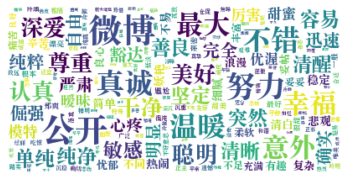

In [41]:
#分词，将内容拷贝到txt，加入自己的词典emotion
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import jieba
import jieba.posseg as pseg

text=open(r'/Users/wang859923/Desktop/spider.txt', 'r',encoding='utf-8').read().replace('\n','')  #文件储存 记得改文件名！！！
jieba.load_userdict("/Users/wang859923/Desktop/emotion.txt")  #改成你的电脑上emotion存储路径！！！
words=jieba.posseg.cut(text)
nwords = ''
for item in words:
    if(item.flag == 'a' or item.flag == 'ad' or item.flag == 'ag' or item.flag == 'an'):
        nwords += str(item.word) + ' '
        
seg_list = jieba.lcut(nwords)
text_cut ='/'.join(seg_list)

WordCloud(font_path='/System/Library/Fonts/Supplemental/Songti.ttc') 
#字体路径，需要展现什么字体就把该字体路径+后缀名写上，如：font_path = '黑体.ttf'
# windows系统一般都是这个路径C:\windows\Fonts\xxxxx.TTF  xxx为字体名

wordcloud = WordCloud(background_color="white", max_font_size=40,font_path='/System/Library/Fonts/Supplemental/Songti.ttc').generate(text_cut)
#字体路径，需要展现什么字体就把该字体路径+后缀名写上，如：font_path = '黑体.ttf'
# windows系统一般都是这个路径C:\windows\Fonts\xxxxx.TTF  xxx为字体名
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
# print("/".join(words))
from collections import Counter
from pprint import pprint
c=Counter()
for i in nwords.split(' '):
    if len(i) > 1:
        c[i]+=1
pprint(c.most_common(30))

[('幸福', 24),
 ('成功', 9),
 ('突然', 8),
 ('努力', 7),
 ('不同', 7),
 ('最好', 6),
 ('容易', 6),
 ('美好', 6),
 ('完全', 6),
 ('漂亮', 5),
 ('年轻', 5),
 ('热爱', 5),
 ('浪漫', 5),
 ('温柔', 5),
 ('善良', 4),
 ('彻底', 4),
 ('微博', 4),
 ('仗义', 4),
 ('确实', 4),
 ('直接', 3),
 ('很好', 3),
 ('热烈', 3),
 ('重新', 3),
 ('尴尬', 3),
 ('凸显', 3),
 ('重要', 3),
 ('坎坷', 3),
 ('幸运', 3),
 ('公开', 3),
 ('糟糕', 3)]


In [10]:
sum=0
for i in c.values():
    sum+=i
print(sum)

329
